In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, DateType
from pyspark.sql.types import ArrayType, DoubleType, IntegerType, LongType
from pyspark.sql.functions import lit, col
from pyspark.mllib.stat import Statistics
from pyspark.mllib.tree import RandomForest
from pyspark.mllib.regression import LabeledPoint
import pyspark.sql.functions as F
from pyspark import SparkContext

from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer, VectorAssembler, OneHotEncoder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator



def loadMongoRDD(db, collection):
    '''
    Download data from mongodb and store it in RDD format
    '''

    spark = SparkSession \
        .builder \
        .master(f"local[*]") \
        .appName("myApp") \
        .config('spark.jars.packages', 'org.mongodb.spark:mongo-spark-connector_2.12:3.0.1') \
        .getOrCreate()

    dataRDD = spark.read.format("mongo") \
        .option('uri', f"mongodb://10.4.41.48/{db}.{collection}") \
        .load() \
        .rdd \
        .cache()

    return dataRDD, spark

def loadMongoDF(db, collection):
    '''
    Download data from mongodb and store it in DF format
    '''
    spark = SparkSession \
        .builder \
        .master(f"local[*]") \
        .appName("myApp") \
        .config('spark.jars.packages', 'org.mongodb.spark:mongo-spark-connector_2.12:3.0.1') \
        .getOrCreate()

    dataDF = spark.read.format("mongo") \
        .option('uri', f"mongodb://10.4.41.48/{db}.{collection}") \
        .load()

    return dataDF, spark


def uploadDFtoMongo(df1, df2, spark):
    '''
    Upload the final KPI data to mongodb
    '''

    df1.write \
        .format("com.mongodb.spark.sql.DefaultSource") \
        .mode("overwrite") \
        .option('uri', f"mongodb://10.4.41.48/exploitation.kpi1") \
        .save()

    df2.write \
        .format("com.mongodb.spark.sql.DefaultSource") \
        .mode("overwrite") \
        .option('uri', f"mongodb://10.4.41.48/exploitation.kpi2") \
        .save()


def mean(x, var):
    suma = 0
    num = len(x)
    for i in range(0,num):
        suma = suma + x[i][var]
    mean = suma/num

    return float("{:.2f}".format(mean))


def counter(x):
    counter = 0
    num = len(x)
    for i in range(0,num):
        counter = counter + 1

    return counter


def generateKPIs():

    rdd, spark = loadMongoRDD(db='formatted', collection='nested_data')

    # KPI 1: to know the average of price asked for a flat/apartment per neighborhood + num apartaments to be rent/saled
    rdd1 = rdd.map(lambda x: (x['Neighborhood'], mean(x['Info Idealista'], 'price'), counter(x['Info Idealista'])))
    #rdd1.foreach(lambda r: print(r))
    df1 = rdd1.toDF(['neighborhood', 'average_price', 'n_listings'])

    # KPI 2: correlación entre monthly price and RFD (family income index)
    rdd2 = rdd.map(lambda x: (x['Monthly Price (€/month)'], x['RFD most recent']))
    #print(Statistics.corr(rdd2, method="pearson")) #corr of 0.98
    #kpi2DF = spark.createDataFrame(pd.DataFrame(Statistics.corr(rdd2, method="pearson"), columns=['monthly_price_corr', 'RFD_corr']))
    df2 = rdd2.toDF(['Monthly Price (€/month)', 'RFD most recent'])

    ## ---------- Upload Descriptive KPIs to mongoDB ----------
    ## 
    uploadDFtoMongo(df1, df2, spark)

generateKPIs()
    


:: loading settings :: url = jar:file:/Users/efwerr/miniforge3/envs/bdm_env/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /Users/efwerr/.ivy2/cache
The jars for the packages stored in: /Users/efwerr/.ivy2/jars
org.mongodb.spark#mongo-spark-connector_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-c05b8a52-08f0-4734-aa2f-0438cf6524d0;1.0
	confs: [default]
	found org.mongodb.spark#mongo-spark-connector_2.12;3.0.1 in central
	found org.mongodb#mongodb-driver-sync;4.0.5 in central
	found org.mongodb#bson;4.0.5 in central
	found org.mongodb#mongodb-driver-core;4.0.5 in central
:: resolution report :: resolve 150ms :: artifacts dl 5ms
	:: modules in use:
	org.mongodb#bson;4.0.5 from central in [default]
	org.mongodb#mongodb-driver-core;4.0.5 from central in [default]
	org.mongodb#mongodb-driver-sync;4.0.5 from central in [default]
	org.mongodb.spark#mongo-spark-connector_2.12;3.0.1 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifact

In [ ]:
import pandas as pd
import pyspark
import datetime
import os
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql.functions import col, lit
from pyspark.sql.types import IntegerType

spark = SparkSession \
        .builder \
        .master(f"local[*]") \
        .appName("myApp") \
        .config('spark.jars.packages', 'org.mongodb.spark:mongo-spark-connector_2.12:3.0.2') \
        .getOrCreate()

kpi1DF = spark.read.format("mongo")\
        .option('uri', f"mongodb://10.4.41.48/exploitation.kpi1") \
        .load()
        
df = kpi1DF.toPandas()

## KPI Visualizations

In [41]:
df

,average_price,n_listings,neighborhood
0,320000.00,1,El Camp de l'Arpa del Clot
1,117250.00,4,Ciutat Meridiana
2,353573.79,129,El Raval
3,286960.32,126,Hostafrancs
4,134750.00,6,Trinitat Vella
5,309000.00,1,Navas
6,239793.51,231,La Marina de Port
7,618150.94,53,El Putxet i el Farró
8,320000.00,1,El Congrés i els Indians
9,333000.00,5,La Font d'en Fargues


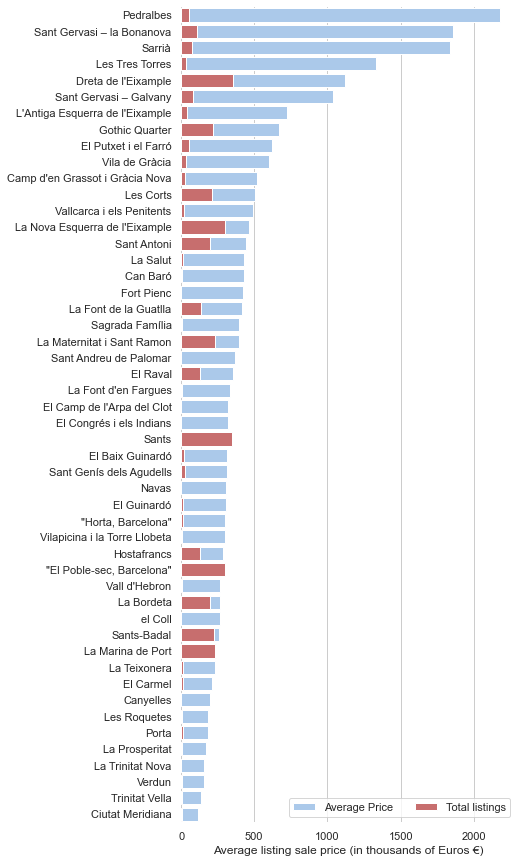

In [88]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

sorted_kpi1 = df.sort_values('average_price', ascending=False)
sorted_kpi1['scaled_price'] = sorted_kpi1['average_price'] / 1000

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(6, 15))

# Plot the average listing price per neighborhood
sns.set_color_codes("pastel")
sns.barplot(x="scaled_price", y="neighborhood", data=sorted_kpi1,
            label="Average Price", color="b")

# Plot the crashes where alcohol was involved
sns.set_color_codes("muted")
sns.barplot(x="n_listings", y="neighborhood", data=sorted_kpi1,
            label="Total listings", color="r")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(ylabel="", xlabel="Average listing sale price (in thousands of Euros €)")
sns.despine(left=True, bottom=True)

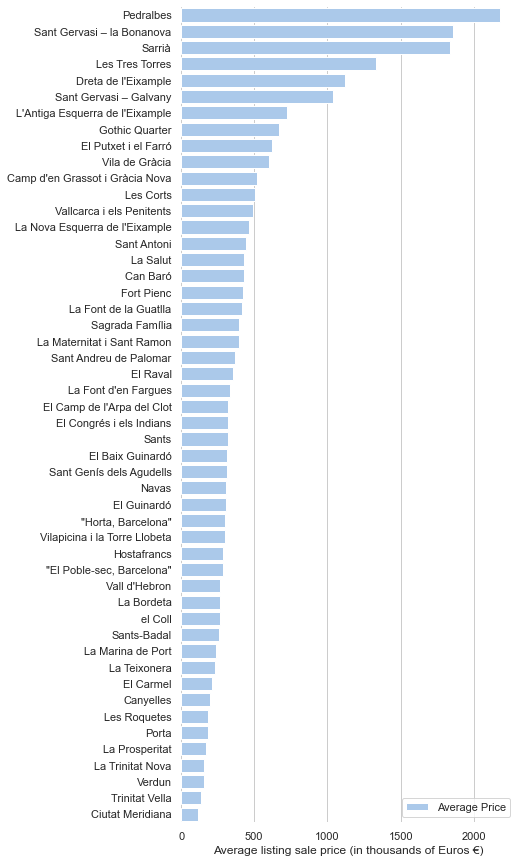

In [89]:
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(6, 15))

# Plot the average listing price per neighborhood
sns.set_color_codes("pastel")
sns.barplot(x="scaled_price", y="neighborhood", data=sorted_kpi1,
            label="Average Price", color="b")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(ylabel="", xlabel="Average listing sale price (in thousands of Euros €)")
sns.despine(left=True, bottom=True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


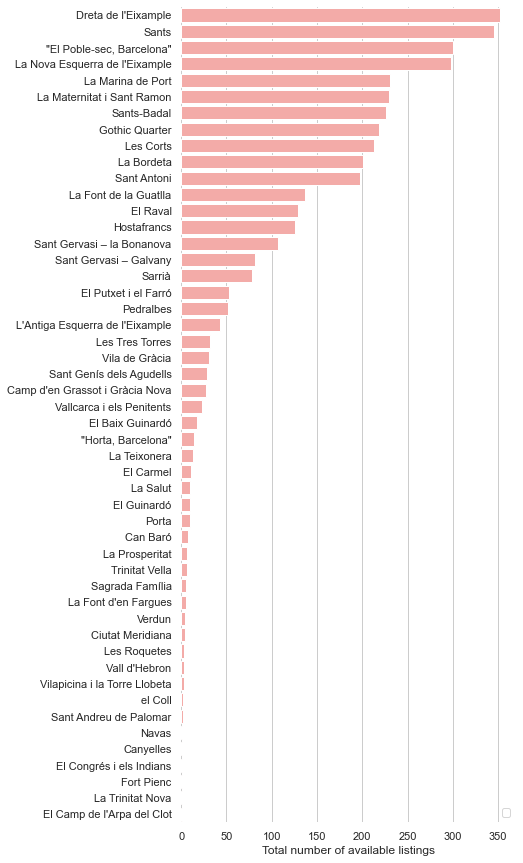

In [80]:
sorted_kpi1 = df.sort_values('n_listings', ascending=False)

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(6, 15))

# Plot the total number of listings per neighborhood
sns.set_color_codes("pastel")
sns.barplot(x="n_listings", y="neighborhood", data=sorted_kpi1, color="r")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(ylabel="", xlabel="Total number of available listings")
#ax.yaxis.set_label_position('right')
#ax.yaxis.tick_right()
sns.despine(left=True, bottom=True)

AttributeError: 'numpy.ndarray' object has no attribute 'legend'

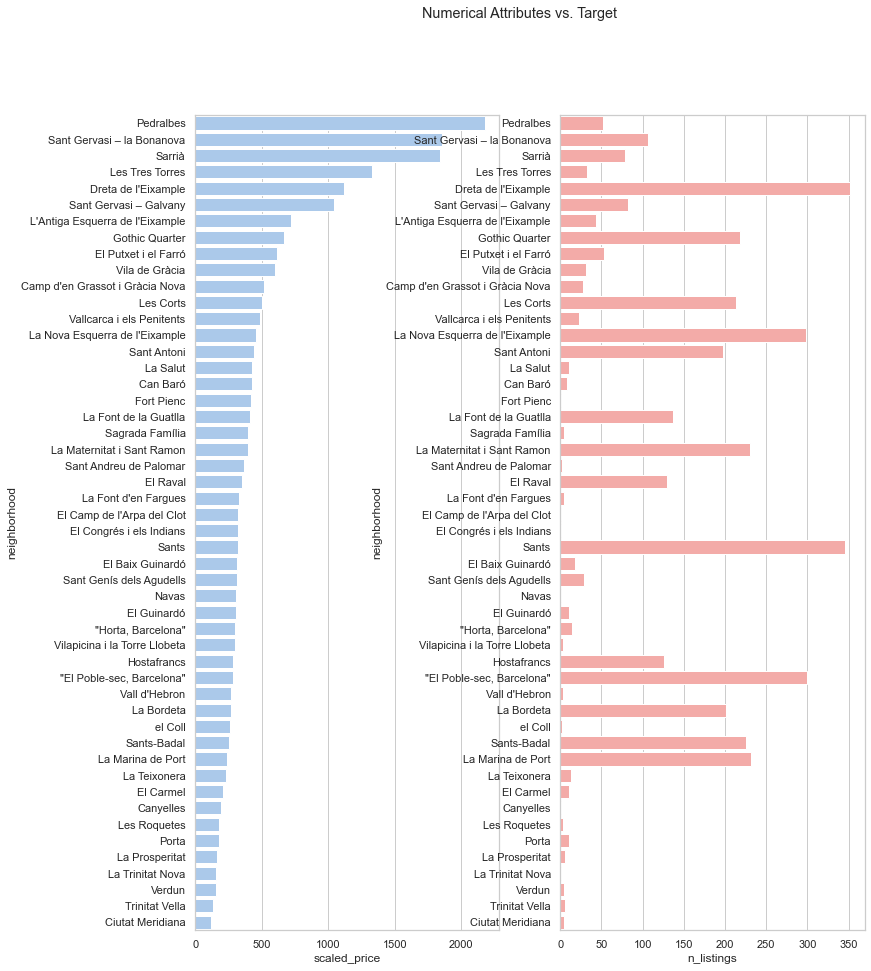

In [103]:
fig, ax = plt.subplots(1,2,figsize=(12,15))
fig.suptitle('Numerical Attributes vs. Target')

# Plot the average listing price per neighborhood
sns.set_color_codes("pastel")
sns.barplot(x="scaled_price", y="neighborhood", data=sorted_kpi1, label="Average Price", color="b", ax=ax[0])

# Plot the total number of listings per neighborhood
sns.set_color_codes("pastel")
sns.barplot(x="n_listings", y="neighborhood", data=sorted_kpi1, color="r", ax=ax[1])

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(ylabel="", xlabel="Average listing sale price (in thousands of Euros €)")
sns.despine(left=True, bottom=True)
